In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Data Loading
df = pd.read_csv('../data/Task 3 and 4_Loan_Data.csv')
df = df.set_index('customer_id')
fico_scores = df['fico_score']

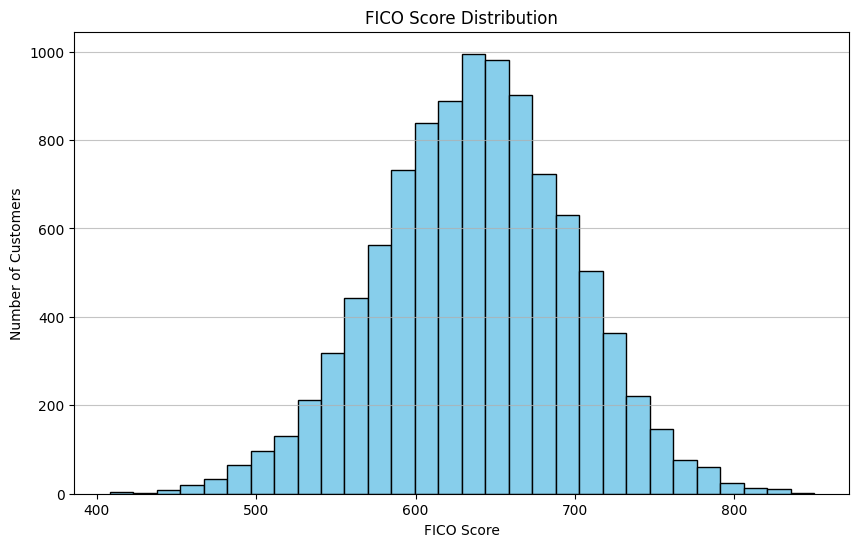

In [4]:
# Plotting FICO score distribution
plt.figure(figsize=(10,6))
plt.hist(fico_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('FICO Score Distribution')
plt.xlabel('FICO Score')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.75)
plt.show()